In [1]:
#importing libraries
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc


!pip install wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression


In [2]:
data = pd.read_csv("C:/Users/navna/Downloads/archive (2)/US_Accidents_Dec21_updated.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Severity               int64  
 2   Start_Time             object 
 3   End_Time               object 
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object 
 10  Number                 float64
 11  Street                 object 
 12  Side                   object 
 13  City                   object 
 14  County                 object 
 15  State                  object 
 16  Zipcode                object 
 17  Country                object 
 18  Timezone               object 
 19  Airport_Code           object 
 20  Weather_Timestamp      object 
 21  Temperature(F)         float64
 22  Wind_Chill(F)     

In [3]:
# Convert Start_Time and End_Time to datetypes
data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce')
data['End_Time'] = pd.to_datetime(data['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
data['Year']=data['Start_Time'].dt.year
data['Month']=data['Start_Time'].dt.strftime('%b')
data['Day']=data['Start_Time'].dt.day
data['Hour']=data['Start_Time'].dt.hour
data['Weekday']=data['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
data[td]=round((data['End_Time']-data['Start_Time'])/np.timedelta64(1,'m'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 53 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               int64         
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   End_Lat                float64       
 7   End_Lng                float64       
 8   Distance(mi)           float64       
 9   Description            object        
 10  Number                 float64       
 11  Street                 object        
 12  Side                   object        
 13  City                   object        
 14  County                 object        
 15  State                  object        
 16  Zipcode                object        
 17  Country                object        
 18  Timezone              

In [4]:
# Check if there is any negative time_duration values
data[td][data[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

In [5]:
# Drop the rows with td<0

neg_outliers=data[td]<=0

# Set outliers to NAN
data[neg_outliers] = np.nan

# Drop rows with negative td
data.dropna(subset=[td],axis=0,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845342 entries, 0 to 2845341
Data columns (total 53 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               float64       
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   End_Lat                float64       
 7   End_Lng                float64       
 8   Distance(mi)           float64       
 9   Description            object        
 10  Number                 float64       
 11  Street                 object        
 12  Side                   object        
 13  City                   object        
 14  County                 object        
 15  State                  object        
 16  Zipcode                object        
 17  Country                object        
 18  Timezone              

In [6]:
# Double check to make sure no more negative td
data[td][data[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

In [7]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = data[td].median()
std = data[td].std()
outliers = (data[td] - median).abs() > std*n

# Set outliers to NAN
data[outliers] = np.nan

# Fill NAN with median
data[td].fillna(median, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845342 entries, 0 to 2845341
Data columns (total 53 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               float64       
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   End_Lat                float64       
 7   End_Lng                float64       
 8   Distance(mi)           float64       
 9   Description            object        
 10  Number                 float64       
 11  Street                 object        
 12  Side                   object        
 13  City                   object        
 14  County                 object        
 15  State                  object        
 16  Zipcode                object        
 17  Country                object        
 18  Timezone              

In [8]:
# Print time_duration information
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(data[td].max(),round(data[td].max()/60), round(data[td].max()/60/24), data[td].min()))

Max time to clear an accident: 28100.0 minutes or 468 hours or 20 days; Min to clear an accident td: 2.0 minutes.


# VISUALIZATION

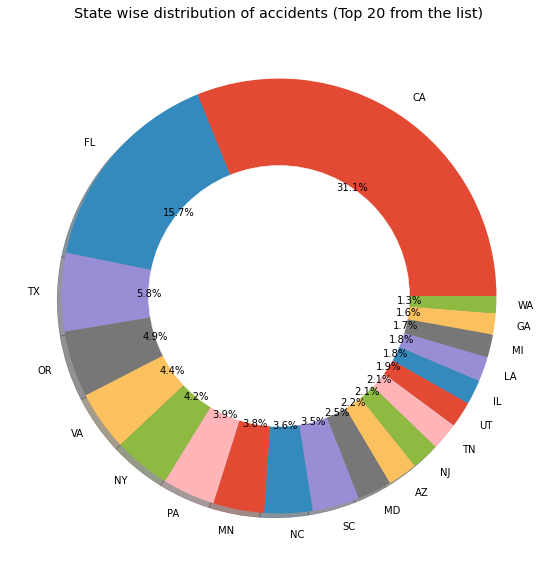

In [10]:
state_counts = data["State"].value_counts()[:20]
plt.figure(figsize=(20, 10))
plt.title("State wise distribution of accidents (Top 20 from the list)")

# Create a pieplot
plt.pie(state_counts.values, labels=state_counts.index, autopct='%1.1f%%', shadow=True)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle((0,0), 0.6 , color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()


In [11]:
data['Accident_hour']=data['Start_Time'].dt.hour
data3=data.groupby(['Accident_hour', 'State'])['ID'].count()
data3=data3.reset_index()
data3.columns=['Accident_hour', 'State', 'Accident_counts']

fig=px.choropleth(data_frame=data3, locations='State', locationmode='USA-states', 
                  color='Accident_counts', animation_frame='Accident_hour', 
                  color_continuous_scale='Reds', 
                  color_continuous_midpoint=round(data3['Accident_counts'].max()/2, -3))

fig.update_layout(
    title_text = 'Accidents for different states at different hours',
    title_x=0.5,
    geo_scope='usa', # limite map scope to USA
)

fig.show()

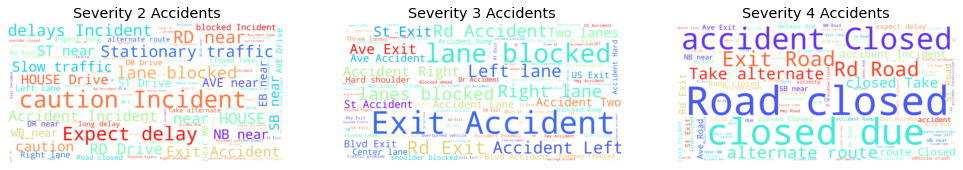

In [12]:
severity_2 = data[data['Severity']==2]['Description']
severity_3 = data[data['Severity']==3]['Description']
severity_4 = data[data['Severity']==4]['Description']

desc_2 = severity_2.str.split("(").str[0].value_counts().keys()
wc_desc_2 = WordCloud(scale=5,max_words=100,colormap="rainbow",background_color="white").generate(" ".join(desc_2))

desc_3 = severity_3.str.split("!").str[0].value_counts().keys()
wc_desc_3 = WordCloud(scale=5,max_words=100,colormap="rainbow",background_color="white").generate(" ".join(desc_3))

desc_4 = severity_4.str.split("!").str[0].value_counts().keys()
wc_desc_4 = WordCloud(scale=5,max_words=100,colormap="rainbow",background_color="white").generate(" ".join(desc_4))

fig, axs = plt.subplots(1,3,sharey=True,figsize=(17,14))

axs[0].imshow(wc_desc_2,interpolation="bilinear")
axs[1].imshow(wc_desc_3,interpolation="bilinear")
axs[2].imshow(wc_desc_4,interpolation="bilinear")

axs[0].axis("off")
axs[1].axis("off")
axs[2].axis("off")

axs[0].set_title('Severity 2 Accidents')
axs[1].set_title('Severity 3 Accidents')
axs[2].set_title('Severity 4 Accidents')

plt.show()

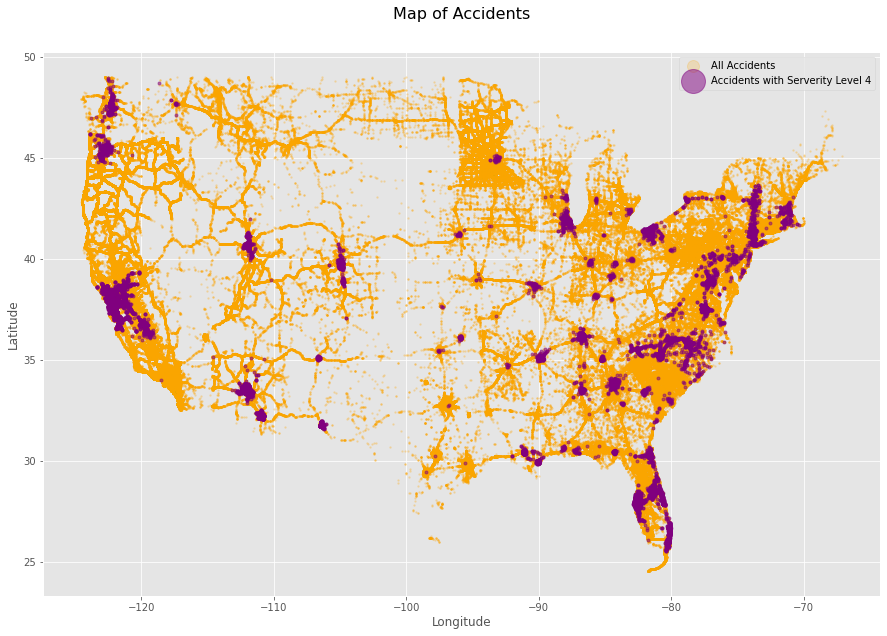

In [13]:
data_4 = data[data['Severity']==1]

plt.figure(figsize=(15,10))

plt.plot( 'Start_Lng', 'Start_Lat', data=data, linestyle='', marker='o', markersize=1.5, color="orange", alpha=0.2, label='All Accidents')
plt.plot( 'Start_Lng', 'Start_Lat', data=data_4, linestyle='', marker='o', markersize=3, color="purple", alpha=0.5, label='Accidents with Serverity Level 4')
plt.legend(markerscale=8)
plt.xlabel('Longitude', size=12, labelpad=3)
plt.ylabel('Latitude', size=12, labelpad=3)
plt.title('Map of Accidents', size=16, y=1.05)
plt.show()

[Text(0.5, 0, 'No. of accidents'), Text(0, 0.5, 'State')]

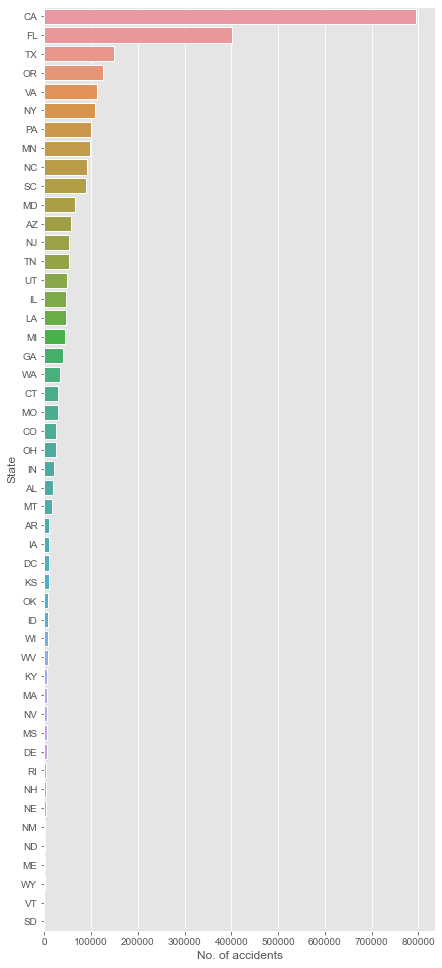

In [14]:
No_of_accidents_by_state=data.groupby('State')['ID'].count().reset_index().sort_values(by = "ID",ascending=False)
ax,fig= plt.subplots(figsize=(7, 17))
sns.set()
ax=sns.barplot(y="State", x='ID', data=No_of_accidents_by_state)
ax.set(xlabel='No. of accidents', ylabel='State')

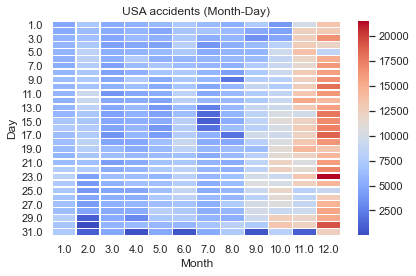

In [15]:
Month_day=pd.crosstab(data['Start_Time'].dt.day, data['End_Time'].dt.month)

ax=sns.heatmap(Month_day,linewidths=.5, cmap='coolwarm')
ax.set_title("USA accidents (Month-Day)")
ax.set(xlabel='Month', ylabel='Day')
plt.tight_layout()

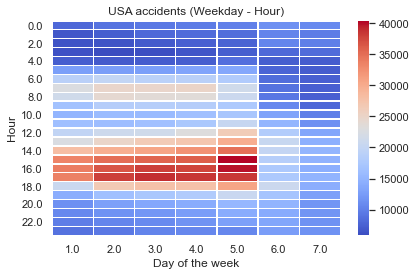

In [16]:
Week_day=pd.crosstab(data['Start_Time'].dt.hour, data['End_Time'].dt.dayofweek+1)
ax1=sns.heatmap(Week_day,linewidths=.5, cmap='coolwarm',)
ax1.set_title("USA accidents (Weekday - Hour)")
ax1.set(xlabel='Day of the week', ylabel='Hour')
plt.tight_layout()

Text(0.5, 1.0, 'Accidents Count By Year')

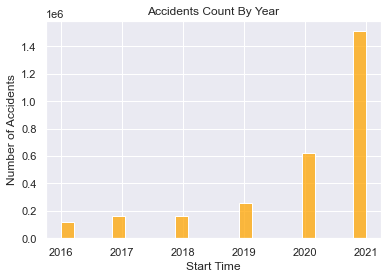

In [17]:
sns.histplot(data.Start_Time.dt.year,bins=24,kde=False,color='orange')

plt.xlabel("Start Time")
plt.ylabel("Number of Accidents")
plt.title('Accidents Count By Year')

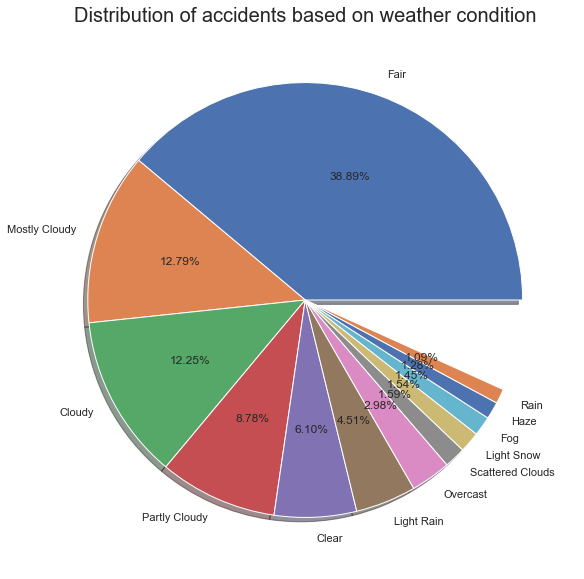

In [18]:
plt.figure(figsize=(20,10))
(data.Weather_Condition.value_counts() / len(data))[0:12].plot(kind='pie',autopct = '%0.2f%%', normalize = False, shadow = True)
plt.ylabel("")
plt.title('Distribution of accidents based on weather condition', fontsize = 20)
plt.show()

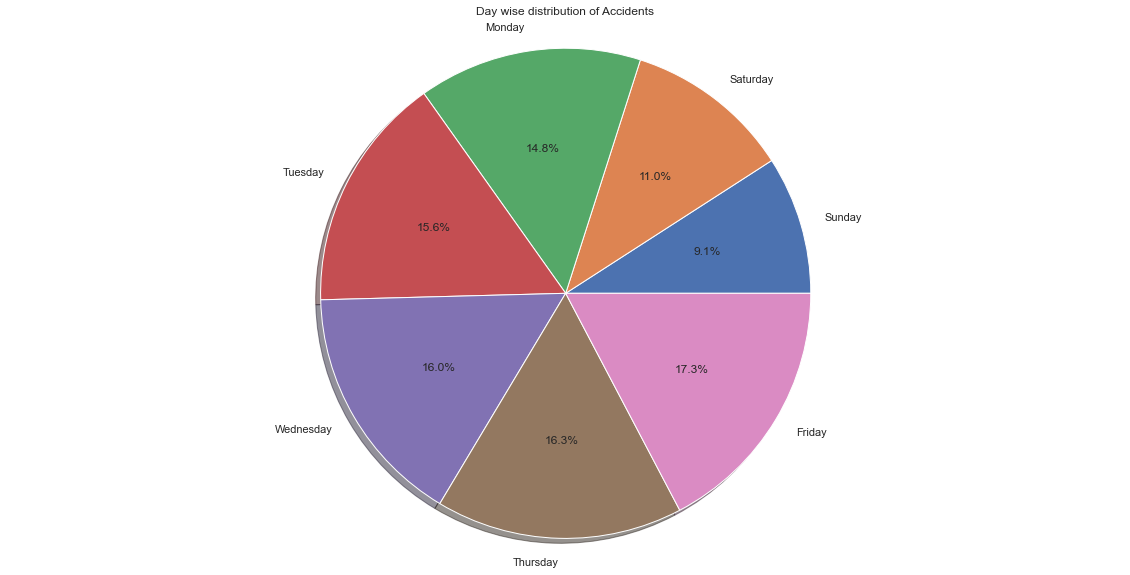

In [19]:
counts = pd.to_datetime(data['Start_Time']).dt.day_name().value_counts(ascending = True)
weekdays = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize = (20,10))
plt.title("Day wise distribution of Accidents")
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.show()
counts = 0

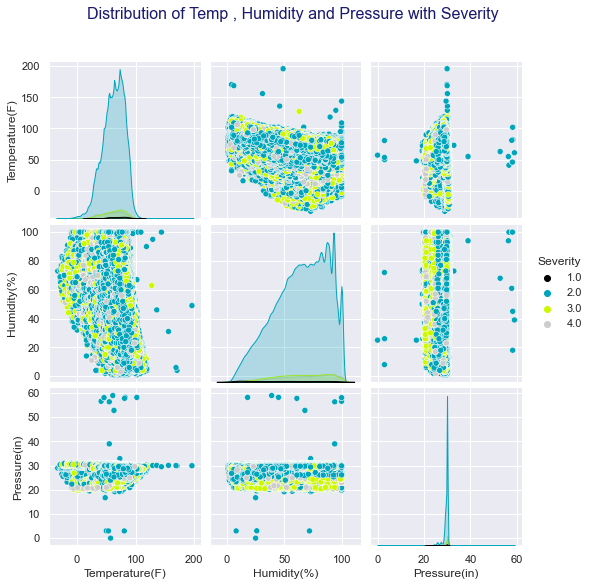

In [20]:
pair = sns.pairplot(data[['Severity','Temperature(F)','Humidity(%)','Pressure(in)']].dropna(), hue='Severity', palette='nipy_spectral')

pair.fig.suptitle('Distribution of Temp , Humidity and Pressure with Severity', y = 1.08 , fontsize = 16 , color = 'MidnightBlue' , ha = 'center' , va='top')

plt.show()

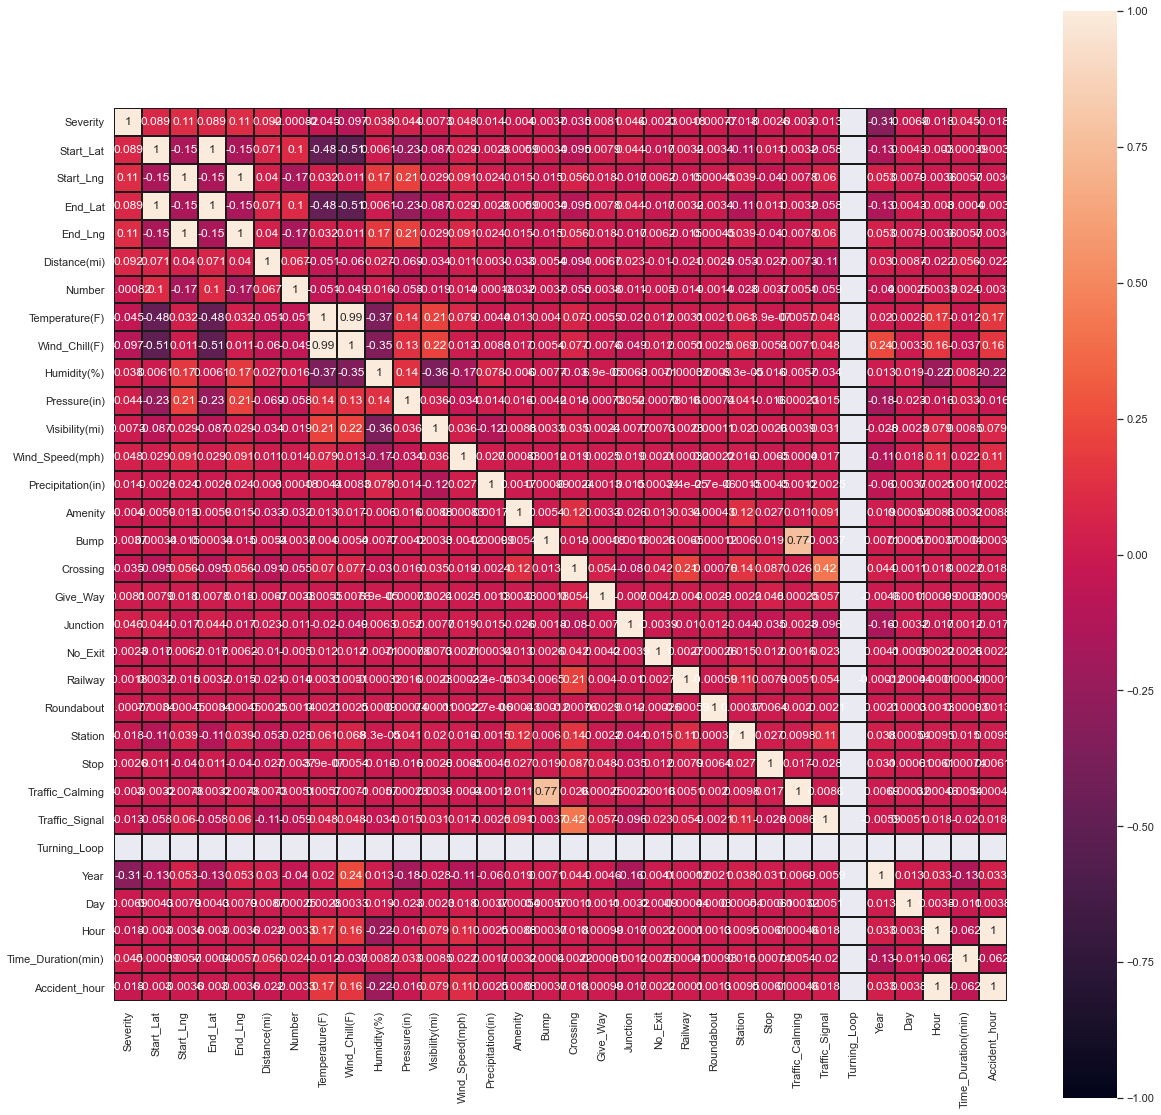

In [21]:
fig=plt.gcf()
fig.set_size_inches(20,20)
fig=sns.heatmap(data.corr(),annot=True,linewidths=1,linecolor='k',square=True,mask=False, vmin=-1, vmax=1,cbar_kws={"orientation": "vertical"},cbar=True)

In [22]:
# Export the data
# data_csv('./US_Accidents_May19_clean.csv',index=False)

In [23]:
# Set the list of features to include in Machine Learning
feature_lst=['Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']

In [24]:
# Select the dataset to include only the selected features
data_sel=data[feature_lst].copy()
data_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845342 entries, 0 to 2845341
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Severity            float64
 1   Start_Lng           float64
 2   Start_Lat           float64
 3   Distance(mi)        float64
 4   Side                object 
 5   City                object 
 6   County              object 
 7   State               object 
 8   Timezone            object 
 9   Temperature(F)      float64
 10  Humidity(%)         float64
 11  Pressure(in)        float64
 12  Visibility(mi)      float64
 13  Wind_Direction      object 
 14  Weather_Condition   object 
 15  Amenity             float64
 16  Bump                float64
 17  Crossing            float64
 18  Give_Way            float64
 19  Junction            float64
 20  No_Exit             float64
 21  Railway             float64
 22  Roundabout          float64
 23  Station             float64
 24  Stop                floa

In [25]:
# Check missing values
data_sel.isnull().mean()

Severity              0.000558
Start_Lng             0.000558
Start_Lat             0.000558
Distance(mi)          0.000558
Side                  0.000558
City                  0.000606
County                0.000558
State                 0.000558
Timezone              0.001843
Temperature(F)        0.024878
Humidity(%)           0.026220
Pressure(in)          0.021353
Visibility(mi)        0.025324
Wind_Direction        0.026458
Weather_Condition     0.025356
Amenity               0.000558
Bump                  0.000558
Crossing              0.000558
Give_Way              0.000558
Junction              0.000558
No_Exit               0.000558
Railway               0.000558
Roundabout            0.000558
Station               0.000558
Stop                  0.000558
Traffic_Calming       0.000558
Traffic_Signal        0.000558
Turning_Loop          0.000558
Sunrise_Sunset        0.001565
Hour                  0.000558
Weekday               0.000558
Time_Duration(min)    0.000000
dtype: f

In [26]:
data_sel.dropna(subset=data_sel.columns[data_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
data_sel.shape

(2732152, 32)

In [27]:
# Set state
state='PA'

# Select the state of Pennsylvania
data_state=data_sel.loc[data_sel.State==state].copy()
data_state.drop('State',axis=1, inplace=True)
data_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96848 entries, 37 to 2844950
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Severity            96848 non-null  float64
 1   Start_Lng           96848 non-null  float64
 2   Start_Lat           96848 non-null  float64
 3   Distance(mi)        96848 non-null  float64
 4   Side                96848 non-null  object 
 5   City                96848 non-null  object 
 6   County              96848 non-null  object 
 7   Timezone            96848 non-null  object 
 8   Temperature(F)      96848 non-null  float64
 9   Humidity(%)         96848 non-null  float64
 10  Pressure(in)        96848 non-null  float64
 11  Visibility(mi)      96848 non-null  float64
 12  Wind_Direction      96848 non-null  object 
 13  Weather_Condition   96848 non-null  object 
 14  Amenity             96848 non-null  float64
 15  Bump                96848 non-null  float64
 16  C

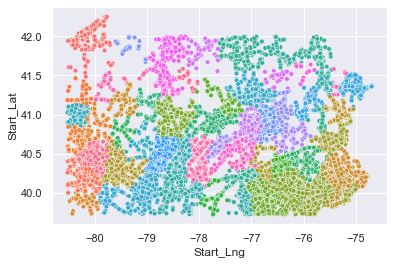

In [28]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=data_state, hue='County', legend=False, s=20)
plt.show()

In [29]:
# Set county
county='Montgomery'

# Select the state of Pennsylvania
data_county=data_state.loc[data_state.County==county].copy()
data_county.drop('County',axis=1, inplace=True)
data_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19831 entries, 31599 to 2844473
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Severity            19831 non-null  float64
 1   Start_Lng           19831 non-null  float64
 2   Start_Lat           19831 non-null  float64
 3   Distance(mi)        19831 non-null  float64
 4   Side                19831 non-null  object 
 5   City                19831 non-null  object 
 6   Timezone            19831 non-null  object 
 7   Temperature(F)      19831 non-null  float64
 8   Humidity(%)         19831 non-null  float64
 9   Pressure(in)        19831 non-null  float64
 10  Visibility(mi)      19831 non-null  float64
 11  Wind_Direction      19831 non-null  object 
 12  Weather_Condition   19831 non-null  object 
 13  Amenity             19831 non-null  float64
 14  Bump                19831 non-null  float64
 15  Crossing            19831 non-null  float64
 16

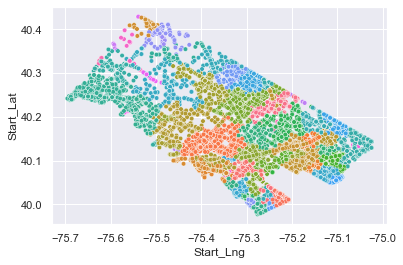

In [30]:
# Map of accidents, color code by city

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=data_county, hue='City', legend=False, s=20)
plt.show()

In [31]:
# Generate dummies for categorical data
data_county_dummy = pd.get_dummies(data_county,drop_first=True)

# Export data
# df_county_dummy.to_csv('./US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

data_county_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19831 entries, 31599 to 2844473
Columns: 163 entries, Severity to Weekday_Wed
dtypes: float64(23), uint8(140)
memory usage: 6.3 MB


In [32]:
# Assign the data
data=data_county_dummy

# Set the target for the prediction
target='Severity'


# Create arrays for the features and the response variable

# set X and y
y = data[target]
X = data.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [33]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

In [34]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

[Logistic regression algorithm] accuracy_score: 0.961.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [35]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

[K-Nearest Neighbors (KNN)] knn.score: 0.962.
[K-Nearest Neighbors (KNN)] accuracy_score: 0.962.


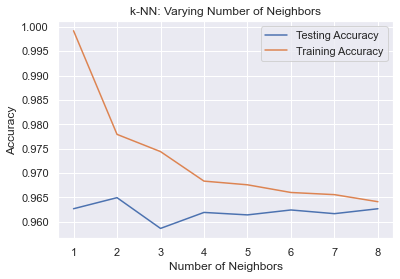

In [36]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a k-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [37]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)


# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))



[Randon forest algorithm] accuracy_score: 0.969.


No handles with labels found to put in legend.


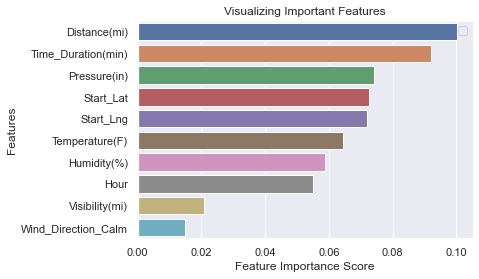

In [38]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()